In [1]:
import numpy as np
import enum
import cmath
import math
import commpy as cpy
import scipy.io
import binascii
from fxpmath import Fxp
import time
import matplotlib.pyplot as plot
#QAM DATA

In [2]:
from pynq import Overlay
ol = Overlay("overlay.bit")
dma= ol.axi_dma_0
dma_send=dma.sendchannel
dma_recv = dma.recvchannel

from pynq import allocate
data_size = 600
input_buffer_ulp = allocate(shape=(data_size,32),dtype='complex64')
input_buffer_uld1 = allocate(shape=(data_size,32),dtype='complex64')
input_buffer_uld2 = allocate(shape=(data_size,32),dtype='complex64')
output_buffer1 = allocate(shape=(data_size,4),dtype="complex64")
output_buffer2 = allocate(shape=(data_size,4),dtype="complex64")


In [3]:
    SNR_array = np.arange(0,40,1)
    #SNR_array = [40]
    frameNr=400
    M=32
    K=4
    Nsub=600
    Concurrence = 1
    n_word = 16
    n_frac = 12

    class OFDMSymbolType(enum.Enum):
        SYNC = 1
        ULP = 2
        ULD = 3
        GUARD = 4
        DLP = 5
        DLD = 6
    #frameSchedule = [OFDMSymbolType.ULP, OFDMSymbolType.ULD, OFDMSymbolType.ULD, OFDMSymbolType.GUARD, 
    #               OFDMSymbolType.DLP, OFDMSymbolType.DLD, OFDMSymbolType.DLD]
    frameSchedule = [OFDMSymbolType.ULP, OFDMSymbolType.ULD, OFDMSymbolType.ULD]


In [4]:
mat = scipy.io.loadmat('matlab.mat')
mat = np.array(mat['channels_write'])
#normalization
factor_raw = 0
for k in range(0,Nsub):
    factor_raw = factor_raw + np.square(np.linalg.norm(mat[k,:,:]))
factor = 1/np.sqrt(factor_raw/(M*K*Nsub))
H_norm = np.full_like(mat,0)
for k in range(0,Nsub):
    for i in range(0,M):
        for j in range(0,K):
            H_norm[k,i,j] = mat[k,i,j]*factor

In [5]:
# variable initlization
OFDMSymbolCounter = 0
SubcarrierCounter = 0
OFDMSymbolCounter_gen = 0
SubcarrierCounter_gen = 0
H_gen = [None]*(Nsub//(K*Concurrence))
currentSymbolType = OFDMSymbolType.SYNC
detMatrixCounterStore = 0
detMatrixCounterFetch = 0

In [6]:
# system specification
def frame_init():
    global qpsk
    global pilots_symbol
    global pilots_lut
    global H_gen
    global data_bits_a,data_bits_b,data_symbol_a,data_symbol_b
    global n_frac 
    global n_word
    

    qpsk = cpy.QAMModem(4)
    pilots_symbol =  scipy.io.loadmat('pilots_py.mat')
    pilots_symbol = np.array(pilots_symbol['pilots_py']).reshape(Nsub)

    
    #pilots_lut = pilots_symbol
    for i in range(0,Nsub//(K*Concurrence)):
        H_gen[i] = H_norm[i*K*Concurrence,:,:]

In [7]:
def channelprocessing():
    global H_gen
    global OFDMSymbolCounter_gen
    global SubcarrierCounter_gen
    global pilots_symbol
    inputVector = np.zeros((M,1),dtype=complex)
    dataVector = np.zeros((K,1),dtype=complex)
    if SubcarrierCounter_gen == Nsub:
        OFDMSymbolCounter_gen = OFDMSymbolCounter_gen + 1
        if OFDMSymbolCounter_gen == 3:
            OFDMSymbolCounter_gen = 0
        SubcarrierCounter_gen = 0
    currentSymbolType_gen = frameSchedule[OFDMSymbolCounter_gen]
    H_use = H_norm[SubcarrierCounter_gen,:,:]
    if currentSymbolType_gen == OFDMSymbolType.ULP:
        pilotVector = np.zeros((K,1),dtype=complex)
        pilotVector[SubcarrierCounter_gen % K,0] = pilots_symbol[SubcarrierCounter_gen]
        inputVector = np.dot(H_use,pilotVector)
    if currentSymbolType_gen == OFDMSymbolType.ULD:
        if OFDMSymbolCounter_gen == 1:
            dataVector[:,0] = data_symbol_a[:,SubcarrierCounter_gen]
        else:
            dataVector[:,0] = data_symbol_b[:,SubcarrierCounter_gen]
        inputVector = np.dot(H_use,dataVector)       
    SubcarrierCounter_gen = SubcarrierCounter_gen + 1
    return inputVector

In [8]:
def flowcontrol(inputVector):
    global OFDMSymbolCounter
    global SubcarrierCounter
    global currentSymbolType
    currentSymbolType = frameSchedule[OFDMSymbolCounter]
    tmpSubcarrierCounter = SubcarrierCounter
    SubcarrierCounter = SubcarrierCounter + 1
    if SubcarrierCounter == Nsub:
        SubcarrierCounter = 0
        OFDMSymbolCounter = OFDMSymbolCounter + 1
        if OFDMSymbolCounter == len(frameSchedule):
            OFDMSymbolCounter = 0
    return tmpSubcarrierCounter, currentSymbolType

In [9]:
data_bits=0
qam = cpy.QAMModem(16)



BER_array = np.zeros((len(SNR_array),K))
frameFactor = frameNr//len(SNR_array)

num_bit_errors = np.zeros(K)
acc_num_bit_errors = np.zeros(K)
tt1=time.time()
for j in range(0,frameNr):
    frame_init()
    print(j)
    target_snr_db = SNR_array[j//frameFactor]
    data_bits_a = np.random.binomial(n=1,p=0.5,size = (Nsub*K*4))
    data_bits_b = np.random.binomial(n=1,p=0.5,size = (Nsub*K*4))
    data_symbol_a = np.array(qam.modulate(data_bits_a)/math.sqrt(10)).reshape(K,Nsub)
    data_symbol_b = np.array(qam.modulate(data_bits_b)/math.sqrt(10)).reshape(K,Nsub)
    data_bits_a = data_bits_a.reshape(K,4*Nsub)
    data_bits_b = data_bits_b.reshape(K,4*Nsub)
    data_bits2_a = np.zeros((K,Nsub*4),dtype = int)
    data_bits2_b = np.zeros((K,Nsub*4),dtype = int)


    data_symbol2_a = np.zeros((K,Nsub),dtype=complex)
    data_symbol2_b = np.zeros((K,Nsub),dtype=complex)

    for i in range(0,Nsub*3): 
        inputVector1 = channelprocessing()

        [tmpSubcarrierCounter, currentSymbolType] = flowcontrol(inputVector1)

        inputVector_n = inputVector1;
        
        if currentSymbolType == OFDMSymbolType.ULP:
            bytes2dma = inputVector_n.astype('complex64').reshape(32,)
            input_buffer_ulp[i]=bytes2dma

        else:
            signal_power = 10*np.log10(np.square(np.linalg.norm(inputVector_n)))
            noise_power = 10**((signal_power - target_snr_db)/10)
            noise = np.random.normal(0, 1, size=(M,2)).view(complex)
            noise_real_power = np.square(np.linalg.norm(noise))
            noise1 = noise*np.sqrt(noise_power/noise_real_power)
            inputVector_n = inputVector_n + noise1
            bytes2dma = inputVector_n.astype('complex64').reshape(32,)
            if i in range(Nsub,Nsub*2):
                input_buffer_uld1[i%Nsub]=bytes2dma
            else:
                input_buffer_uld2[i%Nsub]=bytes2dma

    dma_recv.transfer(output_buffer1)
    dma_send.transfer(input_buffer_ulp)
    dma_send.wait()
    dma_send.transfer(input_buffer_uld1)
    dma_recv.wait()
    dma_recv.transfer(output_buffer2)
    dma_send.transfer(input_buffer_uld2)
    for i in range(0,Nsub):
        data_symbol2_a[:,[i,i]] = (output_buffer1[i]).reshape(4,1)
        data_symbol2_b[:,[i,i]] = (output_buffer2[i]).reshape(4,1)
       
    for k in range(0,K):
        data_bits2_a[k,:] = qam.demodulate(output_buffer1[:,k]*math.sqrt(10),'hard')
        eee= cpy.utilities.hamming_dist(data_bits_a[k,:],data_bits2_a[k,:])
        
        num_bit_errors[k]  = eee
        acc_num_bit_errors[k] = acc_num_bit_errors[k] + num_bit_errors[k]

   
    #data_symbol2_b = data_symbol2_b.reshape(Nsub*K)
    for k in range(0,K):
        data_bits2_b[k,:] = qam.demodulate(output_buffer2[:,k]*math.sqrt(10),'hard')
        num_bit_errors[k] = cpy.utilities.hamming_dist(data_bits_b[k,:],data_bits2_b[k,:])
        acc_num_bit_errors[k] = acc_num_bit_errors[k] + num_bit_errors[k]
    data_bits=data_bits+data_bits_a.size+data_bits_b.size
    if (j+1)%frameFactor == 0:
        BER_array[j//frameFactor] = K*acc_num_bit_errors/data_bits
    
        acc_num_bit_errors = np.zeros(K)
        data_bits = 0
tt2=time.time()
print(tt2-tt1)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

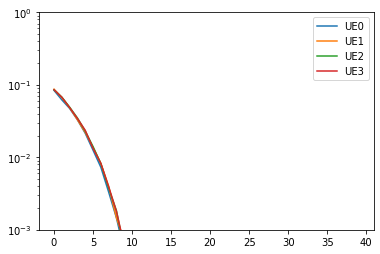

In [10]:
plot.semilogy(SNR_array,BER_array[:,0],label='UE0')
plot.semilogy(SNR_array,BER_array[:,1],label='UE1')
plot.semilogy(SNR_array,BER_array[:,2],label='UE2')
plot.semilogy(SNR_array,BER_array[:,3],label='UE3')
plot.ylim([0.001,1])
plot.legend()